In [1]:
import subprocess
import shlex
import re
import csv

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, combine_pvalues
from IPython.display import display, Markdown
from tqdm import tqdm

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

def show():
    plt.savefig(f"{show.fig_counter}.pdf", dpi='figure', transparent=True, bbox_inches='tight')
    show.fig_counter += 1
    show.plt_show()

show.fig_counter = 0
show.plt_show = plt.show

plt.show = show

In [3]:
CC_PATTERN = re.compile(r"(?<!^)(?=[A-Z])")

# Spearman correlation between four adjacent individuals

In [4]:
def test_rng_correlation(
    mode, seeds=[42], limit=1000,
):
    total_correlations = np.zeros(shape=(4, 4))
    total_pvalues = []
    
    for seed in tqdm(seeds):
        # Collect random streams from non-dispersing individuals at (0,0)..(1,1)
        rngs_io = StringIO(subprocess.run(shlex.split(
            f"cargo run --release --quiet -- --seed {seed} --limit {limit} {CC_PATTERN.sub('-', mode).lower()}"
        ), check=True, capture_output=True, text=True).stdout)
        
        # Read in the random draws and transpose to 4xlimit
        rngs = []
        with rngs_io:
            reader = csv.reader(rngs_io)

            for row in reader:
                rngs.append(tuple(np.uint64(c) for c in row))
        rngs = np.array(rngs).T
        
        zzCzo = spearmanr(rngs[0], rngs[1])
        zzCoz = spearmanr(rngs[0], rngs[2])
        zzCoo = spearmanr(rngs[0], rngs[3])
        zoCoz = spearmanr(rngs[1], rngs[2])
        zoCoo = spearmanr(rngs[1], rngs[3])
        ozCoo = spearmanr(rngs[2], rngs[3])
        
        total_correlations[0,1] += zzCzo.correlation
        total_correlations[1,0] -= zzCzo.correlation
        
        total_correlations[0,2] += zzCoz.correlation
        total_correlations[2,0] -= zzCoz.correlation
        
        total_correlations[0,3] += zzCoo.correlation
        total_correlations[3,0] -= zzCoo.correlation
        
        total_correlations[1,2] += zoCoz.correlation
        total_correlations[2,1] -= zoCoz.correlation
        
        total_correlations[1,3] += zoCoo.correlation
        total_correlations[3,1] -= zoCoo.correlation
        
        total_correlations[2,3] += ozCoo.correlation
        total_correlations[3,2] -= ozCoo.correlation
        
        total_pvalues.append(zzCzo.pvalue)
        total_pvalues.append(zzCoz.pvalue)
        total_pvalues.append(zzCoo.pvalue)
        total_pvalues.append(zoCoz.pvalue)
        total_pvalues.append(zoCoo.pvalue)
        total_pvalues.append(ozCoo.pvalue)
    
    total_correlations /= limit
    
    corr_statistic, corr_pvalue = combine_pvalues(total_pvalues)
    
    if corr_pvalue <= 0.01 or corr_pvalue >= 0.99:
        display(Markdown(f"## {mode}: <span style='color:purple'><u>Definitely Correlated</u></span>"))
    elif corr_pvalue <= 0.05 or corr_pvalue >= 0.95:
        display(Markdown(f"## {mode}: <span style='color:red'><u>Strongly Correlated</u></span>"))
    elif corr_pvalue <= 0.1 or corr_pvalue >= 0.9:
        display(Markdown(f"## {mode}: <span style='color:orange'>*Weakly Correlated*</span>"))
    else:
        display(Markdown(f"## {mode}: <span style='color:green'>Uncorrelated</span>"))
        
    display(Markdown("#### Fisher’s combined Spearman correlation coefficients:"))
    display(Markdown(f"* p-value: {corr_pvalue}\n* statistic: {corr_statistic}"))
    
    plt.title("Distribution of p-values")
    plt.xlabel("p")
    plt.ylabel("pdf")
    plt.hist(total_pvalues, density=True)
    plt.show()
    
    display(Markdown("#### Correlation matrix:"))
    
    plt.figure(figsize=(8, 8))
    mat = plt.matshow(total_correlations, fignum=1)
    mat.axes.set_title("Individual Spearman correlation coefficients")
    mat.axes.set_xticks([0, 1, 2, 3])
    mat.axes.set_yticks([0, 1, 2, 3])
    mat.axes.set_xticklabels(['(0,0)', '(0,1)', '(1,0)', '(1,1)'])
    mat.axes.set_yticklabels(['(0,0)', '(0,1)', '(1,0)', '(1,1)'])
    plt.colorbar()
    plt.show()
    
    display(Markdown(f"#### Parameters:\n* seeds: {seeds}"))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:39<00:00,  6.27it/s]


## NoDispersal: <span style='color:green'>Uncorrelated</span>

#### Fisher’s combined Spearman correlation coefficients:

* p-value: 0.4245155234148622
* statistic: 12028.84619789048

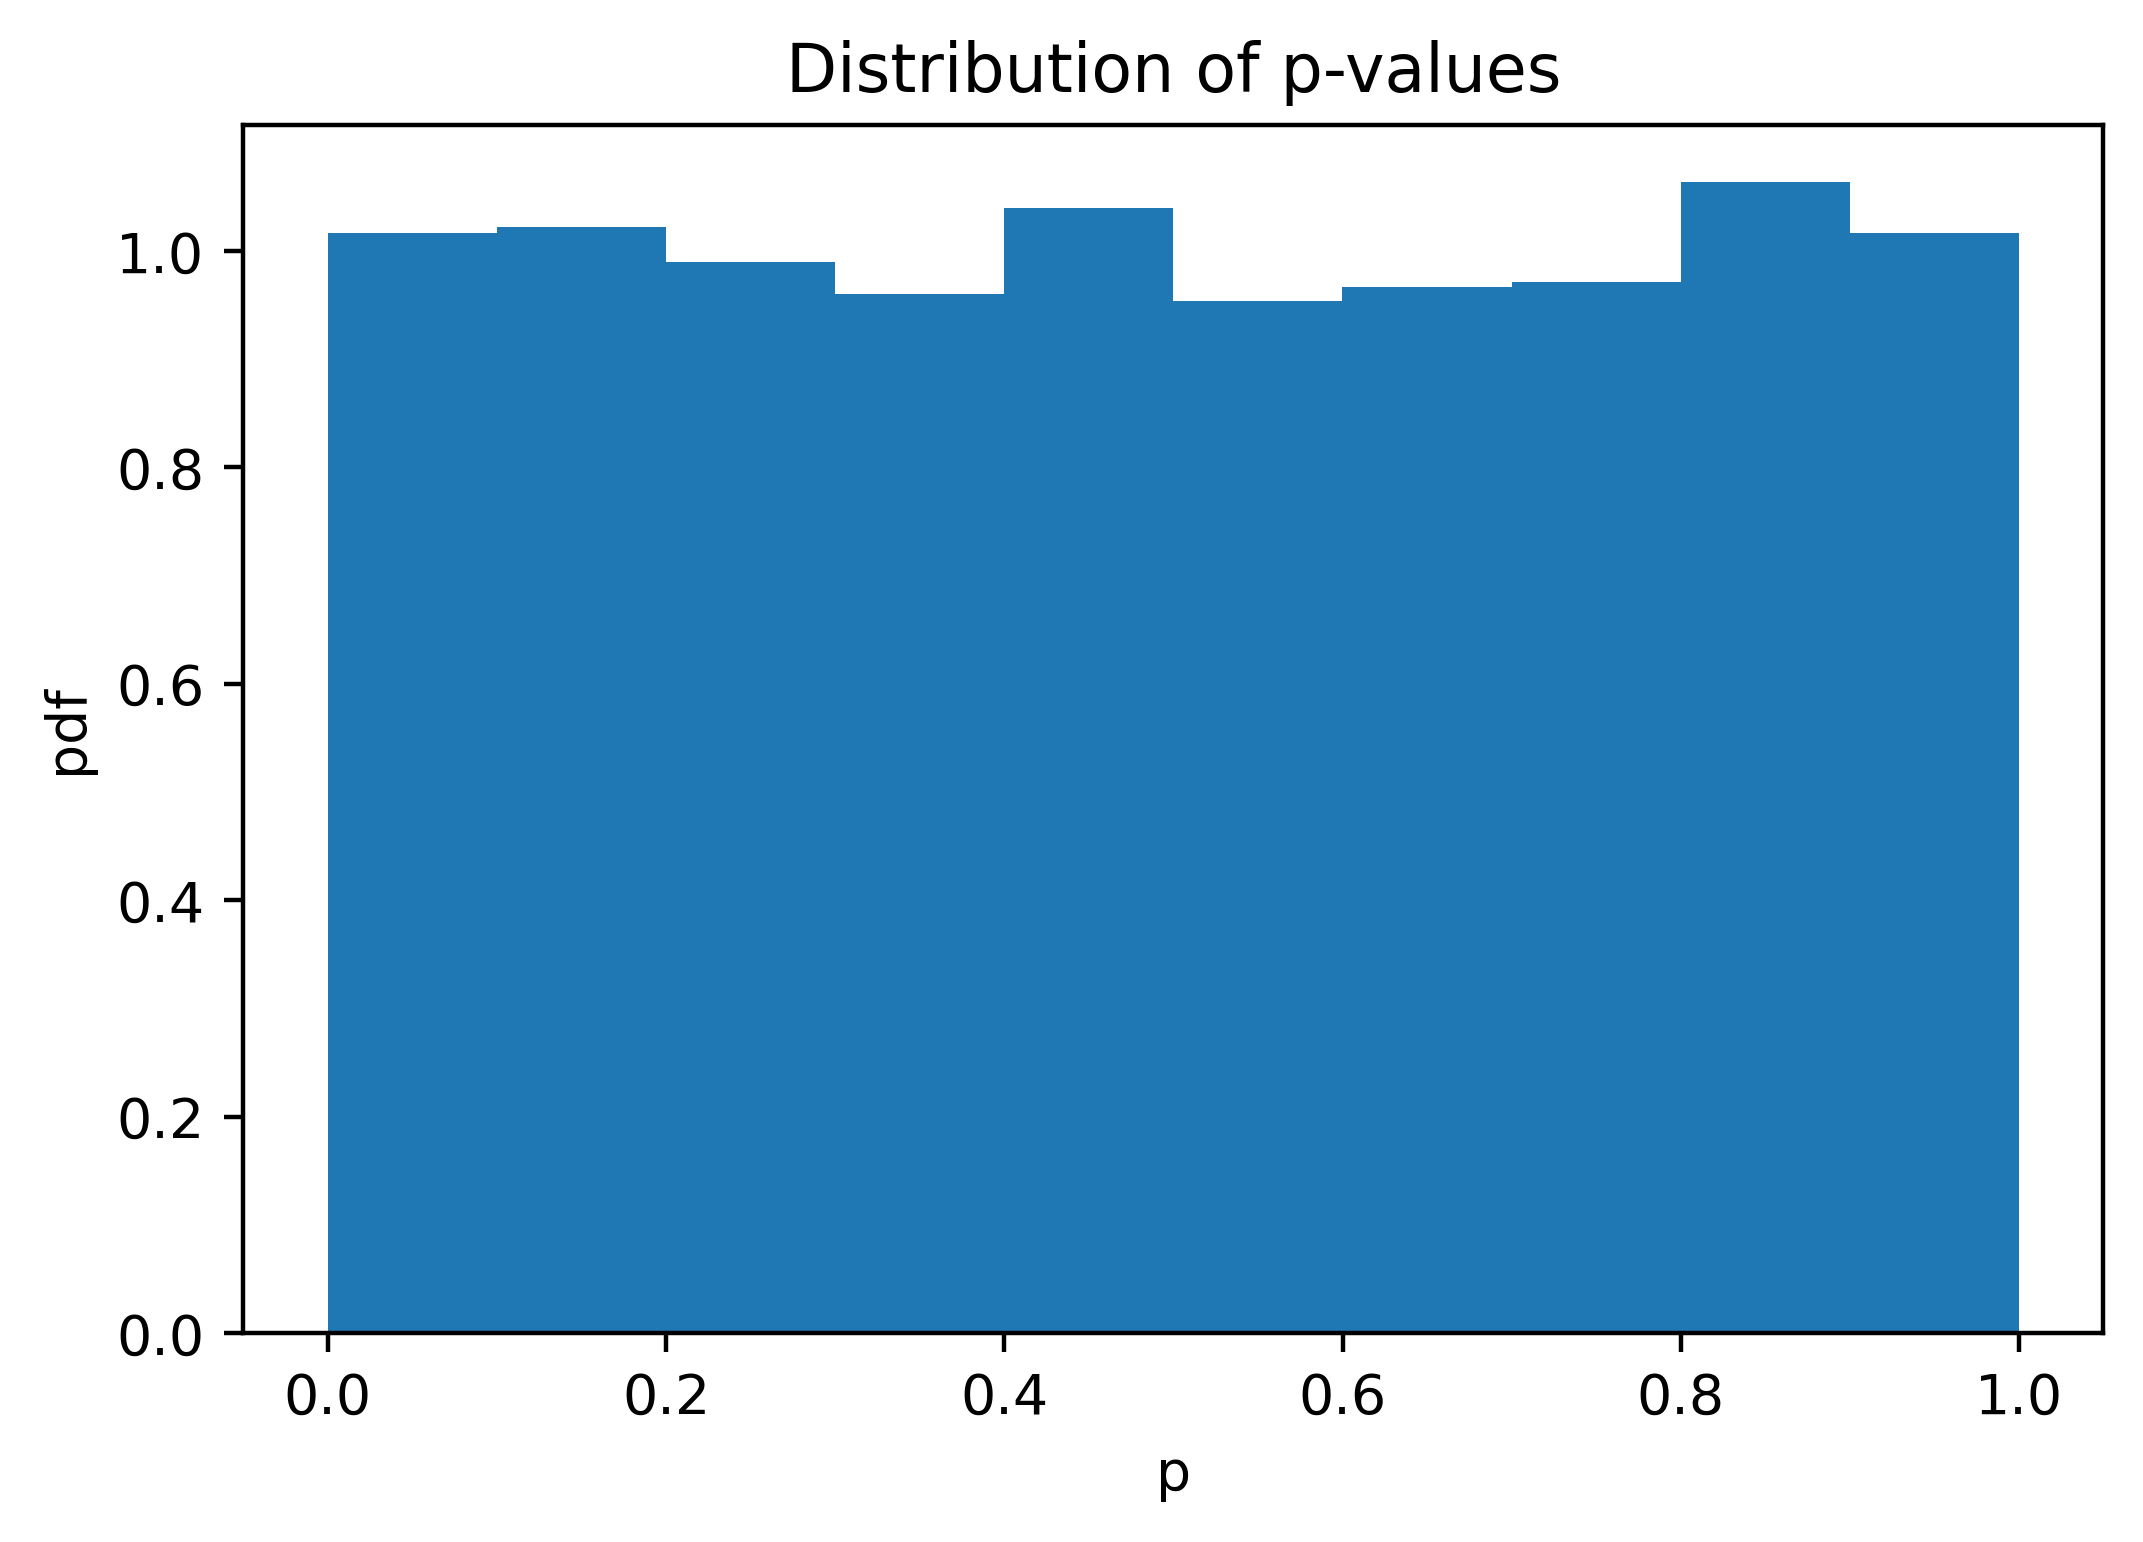

#### Correlation matrix:

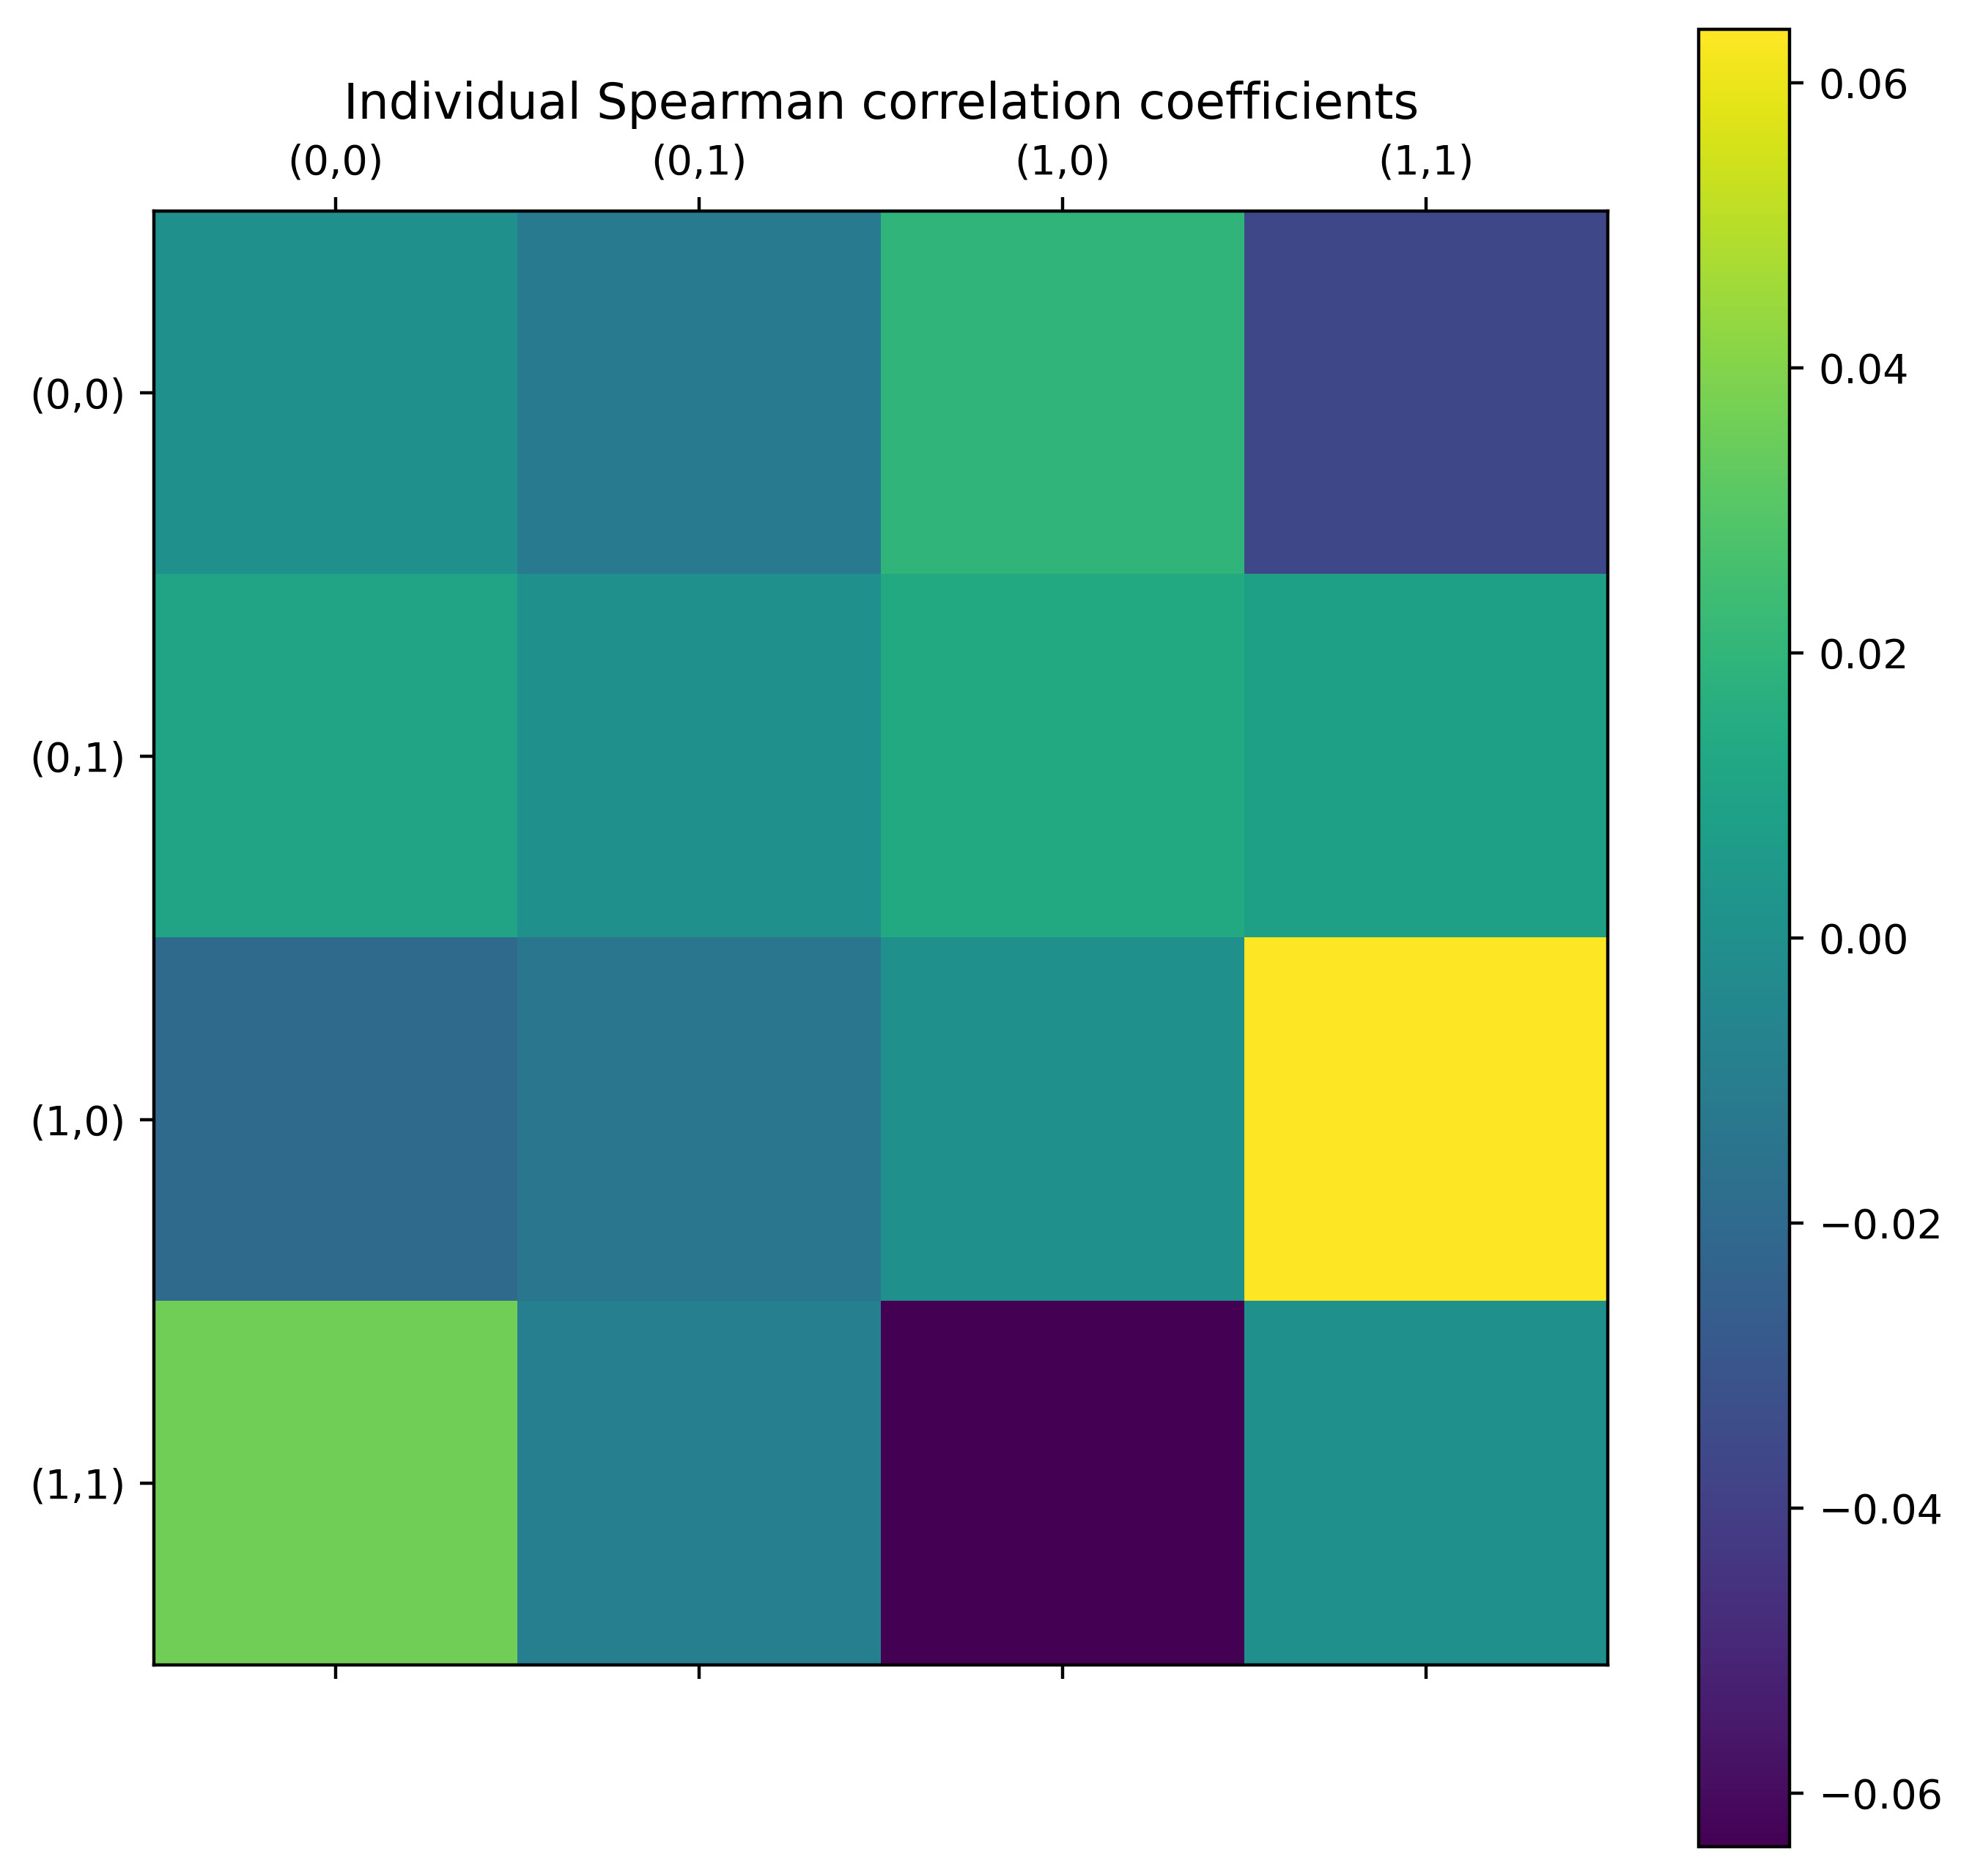

#### Parameters:
* seeds: [14428947011176508832 14736858426685731486  8289753034654546792
  4150316867598506278 11881795696221673230  3552119192975705227
  5124631010534226135  2377742413812670052  1821751964063300161
  2877540944329208955  8878448979834856196 15686138255549117042
 14379762928693624811  6613109365360465816 15155361618711132301
  5897119814003006056  2084592196256942627  1288067667188308134
 17349426760791156437 17023091384744815978 13583358108588286732
  5333848042232710202 11985749698628216864   946649425447654299
 12072289691004294765  9655176728370834754  3566603826879162298
  6046702149993919188 13148096968245274227  1492517518119279237
 18078247523330592001 15817580539913692611  8175509440173509644
 10224022716211673018  3533600760820103784 13909959662689857823
  4409310692282401784  3405123564689778560  2189811992480183244
 15697472827322580581  5790766551551366006 14156746222617715805
  9741729391691668717  1756605913015348952  9950766376526361196
  8946095183712476647  8548024829879855143  3296735777640815865
  8697336946449780064 11178457425186364653  9409650153415135475
 10452608446513009593  1255663535831955230  9425433522244401980
  9320418116774958851  4089982954522295198 11689494933007373795
  4829238315405302679 16922105115137885180  8205712287607501944
  2337869359382442352  8158863282446237437  6225506112794461491
  9042795476143601516 12745496984015940874  4009239797289887383
  9539032056314304760   614761947350390360 13393235626564563071
 18279416968372751626 12024799439466572226 14630659808478590891
  1088593599925463262  3716865682511692422 17025384461706985289
 15864219827390589500  9364380976448269715 15910272631879121118
 17845963099785163023 11652275903007861777  2356653550333996343
 13368971084060896837  4416405667982913576 13754891004324083094
 17196868378422047352 16835420924341262573   512024519464618760
  2483073390589652413 11222974475418714480  6872039861554875268
 15113505218890435941 11209635805911521910 15480385902334128029
 16828662004355768181  9394353192687793308  6377571250623259703
 11060653481255625839  8521149026284826370  6737613829932242181
 12760468086684131853   906010812104048590 14213525664029373831
  4071824706435755602 13322074159996350019  1842306381258371599
  7479670835582496123 15885891376534436630  5613742714458739901
  2894855427071456720  4442949634794451383  6466887952937400779
 15710950062895649538 16979252612688588508  5676423710309852561
  2518564940241570192 10280142576582156082 11334735999855570120
 18308371836034702887  9178209936487457497   581181268772394940
  9279678785626842759  4329040584817053222 10941466902023315567
  3264395147588863027 12168018463140327561   776422598323845578
  8574447769497662076  6992530087305101036  6587712025433539635
  5698330749182442985  2789028836037428955  7288803287165630011
  7701387256519532566  9201811936995876181 16749140499657708628
 16019104221449114615  9007214636596936781 16899749568591606185
 17113475989875490167 10379761272063907294 11739454411644247388
  4274406302607322466 18352752339343388969  5283149654077185276
 17292934872820101385 13808013033283221823  1344540809065544885
 16529931528222374128  9597155604975489111  7400766544644795154
  7214258821404280615    15364052987542149   644079329668294078
  1861628051652425140 15718132274171165635 11563129587539990736
 16693761797169021233 15474860199237723447  7505126988646784801
 14300019618074570197 16255178088536196953  9591121942479762146
  7233755003787361439  5592846721475653019  1080619875150101043
  8939903176093743450  5354861665691187281 14646667015844111026
  7562954552945799828 15972598033237583956  9287582073585080828
  3221794662994706295  5209754656530151136 13396881843519847950
 12976650766958074613 13768159348065758145  7635254909963307045
  3143637101495552026 16945290115495293934 13769363515907339379
 14659841330935333295  1777356781986730048  3819412838523101727
 14149417369391622371 10676718909320273415  7160369956516001606
 11627326384861634713  2298654628255905294      386730570839651
   297689812370482529  5523460362188898060 15080450277961774868
 12801215920847226083  3576700275752272360 13469076301145859889
 15185633001743167102 16655138065677754852 16281026032814324809
  4430538444626300294 10200849974703543048 13289963762459465152
 12841848359942868896  8461857501017233693 15727764845336907771
 17096208995134079119  4053560972313878822    84782949249903718
  6529295651018769600   358575022467153263  7101116946266067658
 10255357555873009788  8425763065080284193  3918097547124310998
 15666601853395375710  9931852901001435111 12989655822097247925
 10338637276806496166  7370044704187877336 15366521981085939961
  4455498809625619952 17710391171181662081  6637258622653110613
 13668381046967738934 14788601801508158827 10926361669836587700
  5431230472210561879    91808055102110644 16134512320975719265
  7640066835855333234 11857304264210199257 14239081902608794796
  3422934744270363810 11662529174664454354 13041693804502638708
 12220530901398891791 12520086450409532266  9835443124689957544
   965149178144959221 15127613031945647837 18355406820779761446
 16316202219076621300 13375579796777887735 11242595155124377948
 14067815223835985779 11459935123681232098  6258387292847146081
  2807368087591125639 17703297859139364782 10507639775219341738
  6761098684901423041  5024978128717489549  3923274391361097106
  5487398733588503379  1716616605975317602 17026001919185273963
 12481847806445673632  9135572672210946761 17520305565208915071
  6205629940703353306  7225212769788421652  8961231752741829262
 13605608896287064490 18419585834386467931 14998200531131238405
 11861204538877956198 13842124824552918217  4092828838030657662
 16890072995146942658 17964533693842721793 17445526117432735976
 18411666237242054569  9505110763321956134 14618660298917223556
 16479410937264839971  1404288988075259880 13727217318595017221
 15049311715147289051 12719264029605877106  1413609970884600640
 11976812607961577829  5188743205484628728 15064014630267996044
 13328019145412390313  7430520731910827411 18147958799023189087
  1005799860580135330 10176771218202576896 10832200982312448564
 15613528012729621738  7679102370918803845 15062260445515933572
 11605654654580495644  1244290571807224381 12818273328878568049
 12909555433297440353 10612055637806160539  3921685496834934252
  1876823892951481135  9556640593554913001 13843943755156136143
  8099100830337656437 17179073414656612843  6749469746182550373
  1612065616437564711  8790825876259418985 14198474770365248738
  4403914858078852422 11689231113457731274  5256646186886985982
  2809820283579028541  6662181276313301882 11211261957949459667
 14795272428180130011  4783461026437796824  2974024342295048347
   423445221190878265  1772439486126404259  3968755751963172496
 10250773246209577461  7320922174882616548 14317553149718587320
  4726131588918103854 12548898678296246644 16715613408252415552
 17759819947411631095 10111183140819707443  5989236131025072319
  6736750386505395385  5247190043647051383  6418175805423196510
 10457844169125616882 11761155390970240955  6517824347958162667
  7040019110415817955 13633845969643138888 17048902004142860263
 17779287566103401856  3361571812261026461 10330319698670044968
 18085960523454491242 10444850929602656329 11838608905769543099
   980985352331749515 11890353741890439745  3076195832000178523
  8570905126236242829 17597770586347044913  3596091748943068637
 11511235407637511281  1818814215579101441 16151396169409327387
  4549809450469045396  7499787790286139338 10594202007914020850
 16421914124624414456  4145379504107022976  2621929132364253570
 12382297909588768050  5748238327343321771   634130730286177884
 14284261817169812983   699144461530271149  9542134530813224628
 10345548303786338728 10379421107931249399  5590771230665382872
 10014987654827104448   761620272172215980 14160585020599308586
  8170875212837466671 14296388003726851671 15879609846315707261
  3615762715277008183  4155210381052197599 11059317639143454841
 16235713103304021850 16935756188156825759  2599009986963234787
 17011632530055562214 13422745688544803081  3703255789888814549
  5672185366722203881  5858976847440066511 16569728942621949055
 15100907747414053713  9778350344379537169 16306477283379396101
  9208193639564806444 10575951447175917866  1251344495176497494
 18148255087859212336  6072606934728503822 11876000794533353692
  3301381453788092252  1161844654066689002 13424504372893855346
 14828909964408453474  6862343705665936904 11356923148823059093
 14341481110965095060 13291599589908784762 16430564558724559961
   960038084712202069 10058263507266889280 13739177803154517658
  9081975373914490438  3891380416121213072 17971254485098437600
  2788917244953508305 11203989648677898793 15175845634459366602
 12479394747805202872  3190385987192904316  7287060779056247713
  2432243289284133934  2023028850632431175  3504653584588677302
  1478321547424903231 12465012399795275684  4109106093674671185
 10458000514890018204  7594734593860635880  3906680705988991587
  3928131318929032929  1755260554893519587  1965666631387708152
  2765439848780511482  4079670472918314062  9259874100632850888
 16685750445748722514 13451521946980902844  4425860849231708956
  8623593273144373947 17927293337330885134 16012801536588215726
 16777823818155635063  8044116025192874060 10047263638030271897
   341004427963837421  7078026379677497691 15767061541398302804
  7266558848963375979 17933060507006898456  7615244602280840217
  2966109254379344432 13632029609252128100 16171291740893018380
  7669356370115168729  7746577530499244734 16074158476052845277
  3970626949010628742 14426641850302415939 14775865685676673601
 11120495045942078593 15040353026947932168  6909810976318083803
  7374579211509330214  1391254233988104102  2706900996898956690
 17589134814619804636 15762569704302861482  4120202873408931133
  2356760836160532311  6400166385681472578 13959458097523056122
 13921762129367234515  3879359258415117934 17205787505872496835
 14265735651351283318  6918220935229124975 17308967162901804425
  2107669878490677100  5237289708061313954  3846012898450102963
 14593539668111479004 17623237424990625461 12678881061619905642
 17167466766131524749 13446614853427864849  1027690815017339923
  7212582578498093708 14580800842062147036  7835270879720757443
  2635146327598253751 17561659190036959177 10400694106272620342
  2294872003916307701 10329749069454708780  7229340443499914826
  8234134893076129725  6635700594103015861  5591797041011205604
 12902377908058065522 15397090940640623866 15877119427782864938
 18186184846585107209  9234853859802096829  8530475214467821543
  4628053994985361868  5421349382717101431 16596298796375082816
 13038127365314582701  2906144412510030967 11330981209993304068
 11758274549546957465 11827645865770328694  2143105377439393563
  9273890796396690994  9211020542715718225  6526143997041904559
 14967913229669718045 14863532451074398253 12662941814645987975
 12679300677464090929  5072047866536513636  2477776571213961550
 13642010827882802257  9522911059889132515 13241733327350108933
  8990542589388753120   349755245507272656 16710668769774586781
  4181554568418497539 14904950349105655797 16386391778275535854
  7095866862149063857 10001487653681606576  3510493358569897647
   164819360614036647  8861865752181787266  1561631821460600007
 17806570580847084630  1683922114059928200  9370960249328702219
 11280501379780996950  4941029684551686159  3616745515018748884
  5961268916563140286 14935438018395126248 16432965521843067952
 13259957948281657943 12605608431868706367 10402675620199402845
  9310118967599407942   517390332208717542  2913791115396380928
  5694190823363642192 13866197213823966475  7803561488052713116
 14130945155912035553 16028259739941073055  7050820218398156766
 15271159547813574300  4551427526821190991 16410705255102283689
  4927504391774099535 15826013747508180742 17155710783318721666
 17030567779544730736 15847640495125859158 11682486897745904048
 13632258909345869813 10543511657636544951 10170945650071474234
 15157466124056321255 15899181468298802587    80426625507432623
 13394574917149892070 14684885331097001910  7174459578831116352
 14160193197889582363  1729724552833985768  6237167380935168184
  3895836814514637802 15125224626547171520  1232327349212868011
 17527992502899307596 11089465821430767372 14430792455071623525
 11428454196476650882  1420687042830062809  3266159893156402309
 11732142252104320140 11272385581822260224  3754664555582273343
  2961378293379909270  1644526754159625979  1083352899054354299
  7332695759461744732  9321268470626350629 10169509080044396950
  1733927950061023810 18403995063715019119  5316074270838583969
 16939788909327407324 18175944912054908145  9611374983335427052
   422401385356279556  3785211081986360745  8222979012504951025
  5077658657457010215 13414546068426443914 16611630087673989052
  6081672258764121164 18401430001840066749  8772562536392906034
  7747304064072918865  9901570558962166825  2056621201551246484
 11892150527160102967   441462013303581204 12339274999782393600
 16871129268270213341 16550400150846375798  2132487346470927934
  7429270074869904732  5681631521111527278 15199056281191460599
  8576521622652368688   444495362099461167 14674935973440577860
   800704983159853330  7573964158575052810 13704350924269546019
  7760348464844781305  7604891071675014380  2162539407541324045
  1304416140696946211 17787230500091891534 10283071542287414153
  4172173844638767838 17017302864559234725 17112093909037165584
  8608592649298294795 13503382709031603693 11521624092677537036
  2721436503026159996 11512702215319119119 13987621463901877477
  5467645541307782971 12383624006013432889  5307183861749903702
   340909025899358582 16997588914551786775  3985108055174954866
  2662757131353145423   539136290218452305  7848478676003060466
 13575123251477311901  6917485842698080757 17193186894057424865
 17397782001492998033  8462665372572430802 13375997436807532773
 10784012789317870966 18402757156356466211   935484408044500976
  8614818360793483937 16237856555052351969  4459388542621129732
 13973975781247676906 11084025439479127222  3874789978223663536
  3136417932428131740  5932311383991162952  4481016050289645464
  2207762866232512734 15592668065879326815  2283786082428013995
   966961590342729004  9886995505327691132 18282819787368697510
  9196699493134902167  9658606844346221014 12367849242683577584
 14727889736398684651 11364369950300830791  8873400793953994529
  5552715590366959070 15270198619583613874 15717426199062239500
 17305168229763085522  7843215372031155310  7570611158002462094
  7301010461665102520 10662521126395544316  6349444882738109944
  8255523468965004176  8567271580258281394 15228315682104885913
 12064806413218147893  8681989075203040354 13573829711513556900
 13263833943978136900  1784542156835507538  4325258913503232143
 16081226409410273241 11638451602169448163  2025329609433664863
  5395800320896230632 10654819751622253840  4077358869055956513
  2250583812164827745 17889215803994633229  7701707335775888562
  5677664867480741543 11201473229009414742  8155034180196143555
 18134587216796334193  3783371717185876164 18112189260557174094
  7356041141234361122  7857324888661601090  9233796331650694146
  4085959140143614917  1875493014456361814 14980366444110738574
 18379920382900536201 10459752889861812381 14051781294673233060
  4594607224445626430  4955537730355836622 15269630148327665234
 17314509464814736348 12355222490829528497 14482461624264610382
  8053834317395988635 12262383334607894234  9234247791636061764
  4248633283491982310  6038991140017212219 16007903870275017806
 17370698261443692818 11765988562000837583 17016149663614642752
   151041114132065345 12185273825753535212 10341775405378412052
  7712648396792208158 10421976988321384137 15782719875340291135
  6113353833437449255  2022325894153869412  1586682458098721003
 13297466348909497707  2733264071761639255   851268623587284368
 12257320211027316870  6063697781983492437 11022078753897891251
  8683219564280538817  2188280451067472518   286307919008545887
 15024250539365014871  9221435720456768754 14862727378511671176
 11161976800654676234 15917340153645090926  3442890559264871526
  4741705565732888354 16379637096871566804 14145023372730531852
  4887887004175292711  2866519929563751524  7517635486262484624
 12654162116545359249  9287164165834343862  9060966625283926758
  7595693687452914990  1066544354841094007  1154007174836834913
 13335500580000824301 17555110193987523607  1909490641689228041
 10380733322553194951  9447614736467577812  1874663636352823361
 13766602020273014873 13135577208696587404  2635064847043204425
 10454944501275237944  6418084635614699023  5946626438007944157
  4911631459255028832  4231798867021472383  6142151643455018987
   369285281813347009 14325762090428183161   916705333065729269
  9472859341154967100  1993369905130042856  2112989937219194568
  9588788001613573359 15113729865189903640  2630370686210979211
  6892807910026433260 14195667515807403132 12557965025990075446
 17412266163156680331 13958797436112712988  3440149781701959654
 17225916322345057172  4239479962335957686  4415020588129585277
  8685053306287583117 12185379857897178197  7279604549416402816
 17581407614902056999  7773242375476793542 15512872282125317245
  6828154031844401076 10198688393656754323   220481111586560121
  8947066642831833015 11414616921781396679 11270851558830218194
 13027363872986386738 16058418528393052527    92374958071496714
  7790591659517723248   701957310404435328 12769808851106625279
 13327983597595366488  4272527084088911330 12409069970729046454
  5530600986639506764  6212263000367006916 15459997591809014780
 18199064472839010338  1878826709221795052  3489798137187748981
 18416194569253195765  9493267162449348335  8008164852440038812
 10020840384182549126 11659141409235489352 16152460825388975309
  7371040460257121281 13976514942607145464  8782299874888192668
 13021292022854583673 18415519310854592534  8171718774131528461
  2583311947874463736  1441589608670467189 13228742830442516267
  1891170187823724001  5079705837940893053 11893356242826689743
 15242733255673684446 18158854827225363760 15509702402397320660
   346768254601142430 12603698008363388229 12293482849725227289
  5661437870612235991 13333901389990231707 18100388732553178391
  6164478744842155213 16550355019378549817  2746109482796968954
 10178551513775627461  7707730369201576789   167695884576503715
 18103689114285602328  1726388858836537149  9973137413057136101
  9168973396818716271 11208223886299184612   292667185744972619
 16474237594766231703 12681820427554425169 12930785513595473800
  7376165809504220656   190821621173909787  1966586797895122386
  7699088871565195585  1058267167969738563 17136904575199162536
  9441173577928649902  2923072515108866234  7527090313099650973
   608569541844395995  1466745084981551934  1348437116998904514
 15920450186737340804 15119300508460619184  2879697160206598788
  4572884155822666679   994923326796822033  6428014675728313022
  3355531392337893912   316694981446705821  9560973815625644078
    62932550320720545 10511581311513854215  5855990713384062090
  4677284494458135123 14129333040828464995  5335238513588472797
 13711111144369970825  2092635031918483452 13391568704660011013
 10042046411928525743  2243745378533405449  7236051146102003153
  8078599262783738597  2458695582979939052 18415241985679770605
  9203215041411805690  4712189989934293842  8250362043188421833
  8441329778705393101  7369073119289870151  6913584168921869161
  3694822699157672921 14860400890578724957 15201475047155377011
 12508404256414287448 10428379882511029990  9824591808327706003
   385796729347433738  1138442844198029485  8060668979230437899
  3520729814400410707 14516416882891524712 14429697342707688545
 10014905683127285123  8922798683710253995  2851718339233119128
  6437598136062701264 18072593834364165728  6279153190263121139
  1578297017415891219  6455703103383781845 15041990024523597432
 13544581241618301832 15989899827083941803 16006668601830869528
  7893952542171844312 17998054161103497261 14533287664252663152
  4456048650150117207 15954551091253002549 17342272342032429153
    79183962887199253  7722244060139595947  6850591305084596790
 17756137880102840656  9261606558711518431  2325514205345897074
 12355270222900826887  4955877800866728140 11360648743516116552
 14132978549474704392 10602899688392194916  3164397104877857102
 18005647549409861026  3902764132790133916  3766699713118862417
 15473056933111012329  2790972894677169826  6868640049358940907
 17387525755938833259  2713698833511353601  4093004881977600471
  3466272850124670288  8723954819730601692 14767715322712997536
  6231315649920544884 10534416541815116807   170411495819217373
 12845890923915075208 13682969214726209300  9365206712196839773
 10606904667167209929 13402011889308421002  9832909602891405160
 10942680311266571302  3410100596671478171  1795693056297756595
 10968319076616937738 15461263628448163445  2376306425184549062
 11025371010909328810  9313074705203635130  2887816900375234931
 10687522701665735891  9467540014667496504 15276058744569520935
  5493218133477682627  6653922671219692804 17025143463842544429
  1906184249568919198  3756335398163548819  8251553557431361696
   626117744959916238   361818545539165427 15020772330194389378
 13640879625814631024]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:10<00:00,  3.99it/s]


## HighDispersal: <span style='color:green'>Uncorrelated</span>

#### Fisher’s combined Spearman correlation coefficients:

* p-value: 0.14794331418906
* statistic: 12161.993745919744

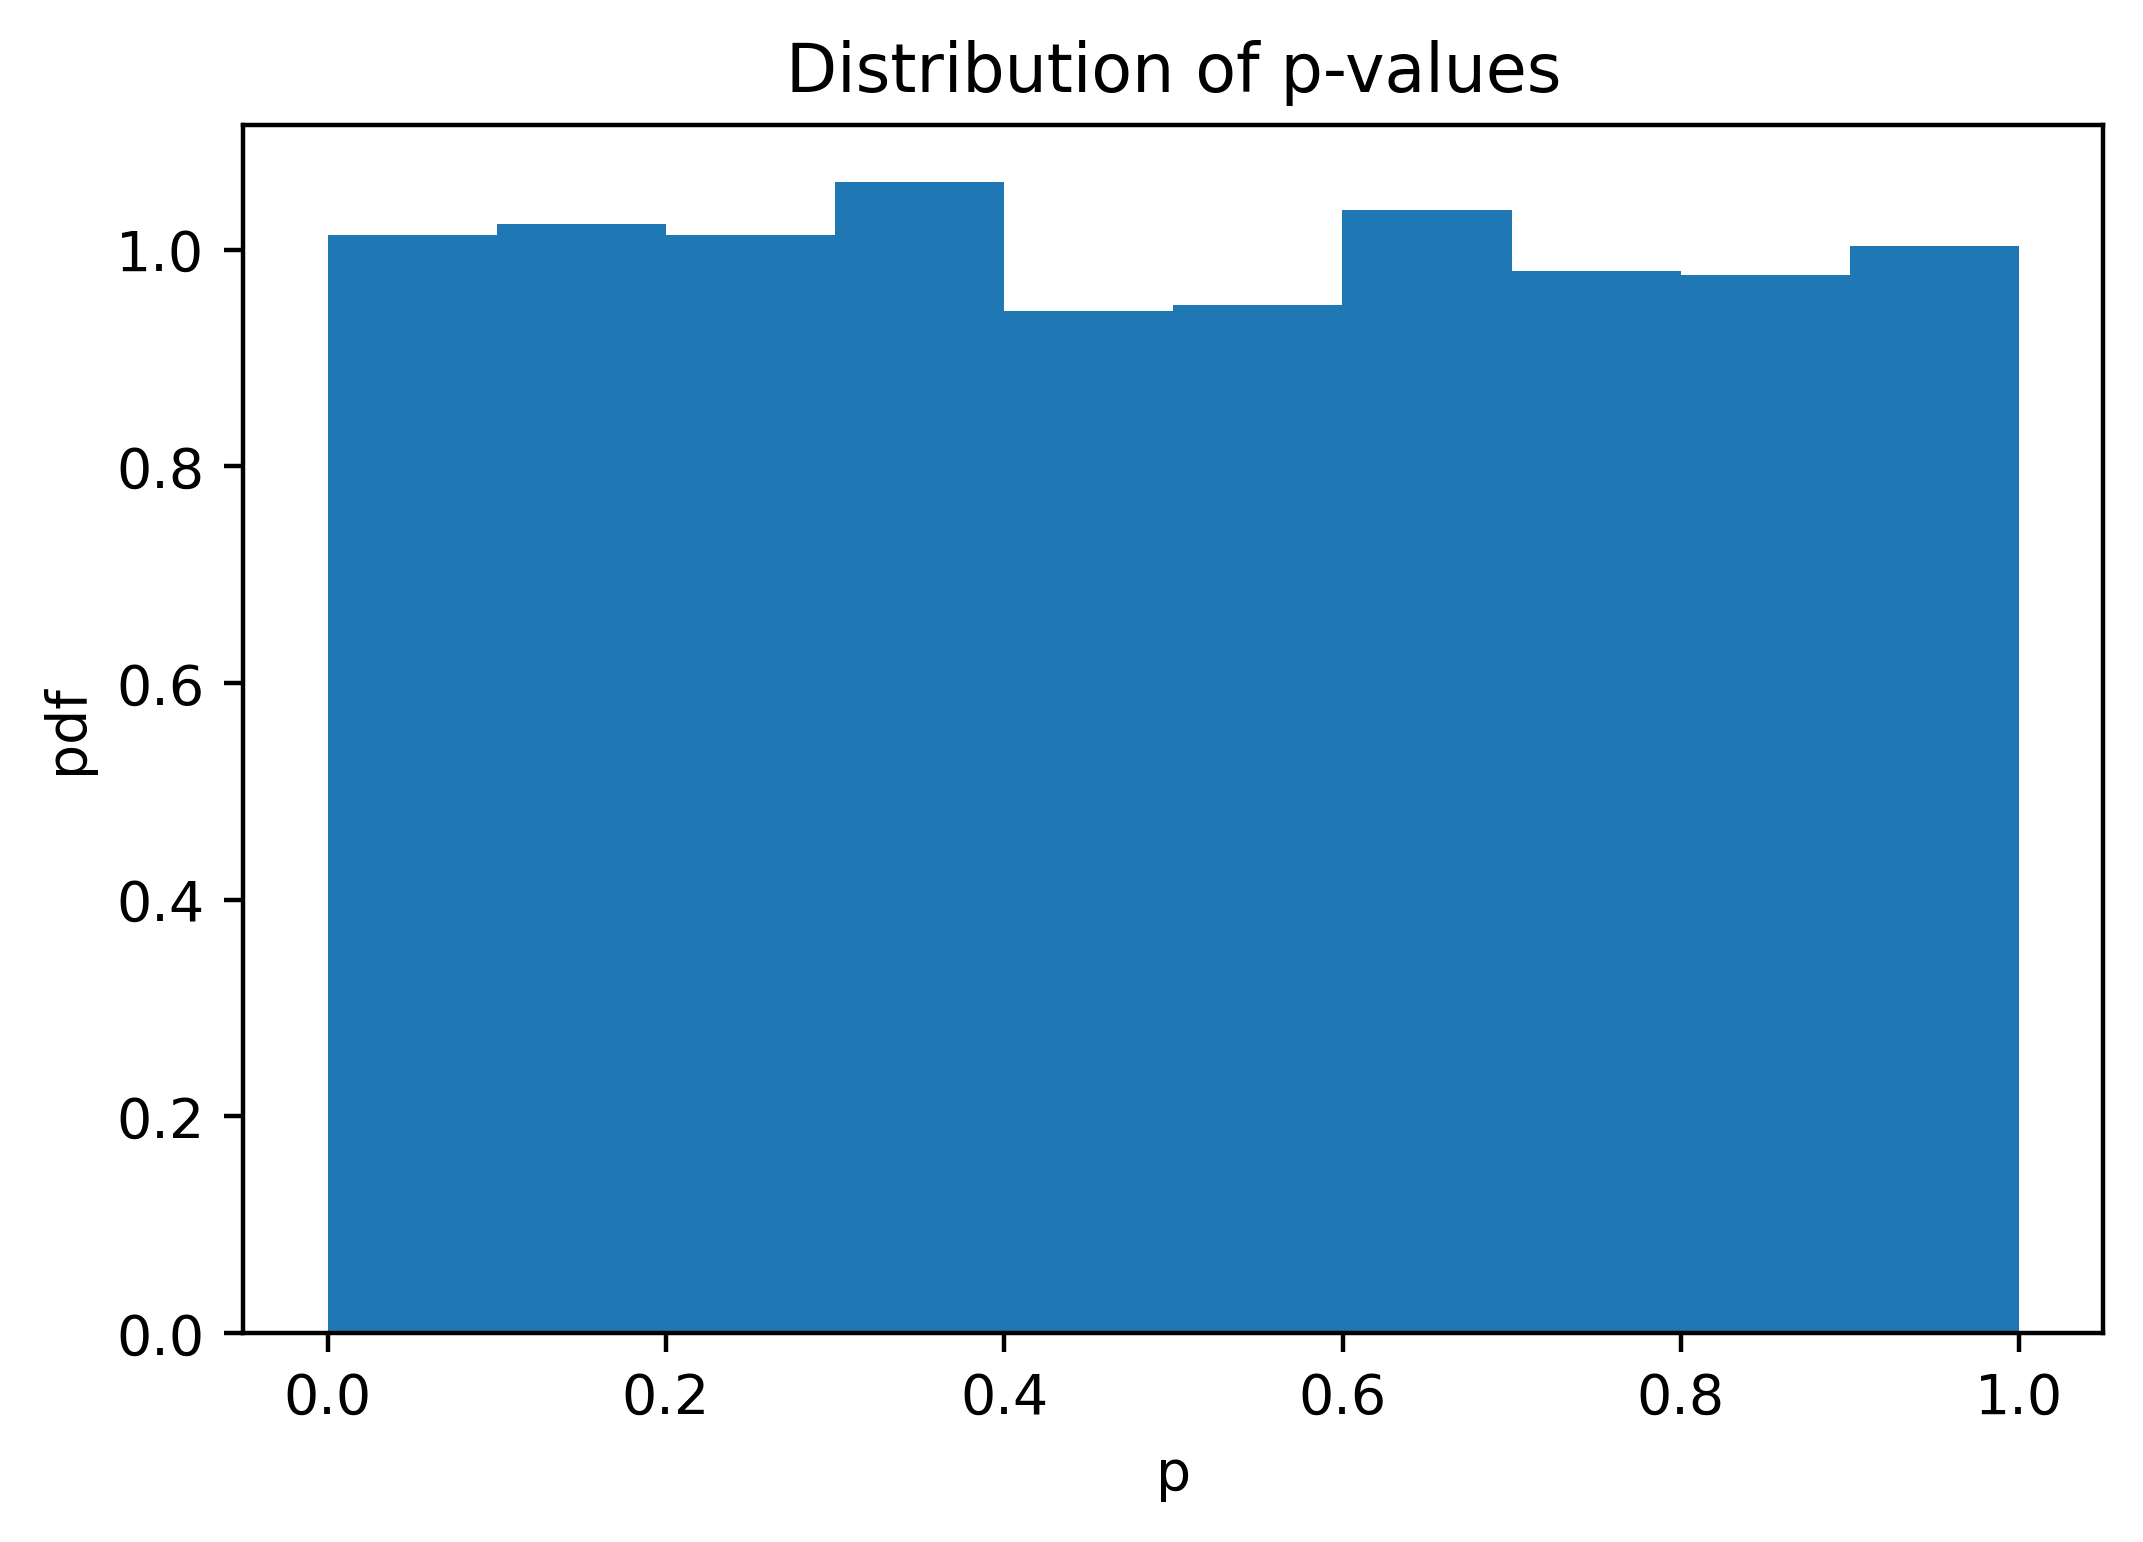

#### Correlation matrix:

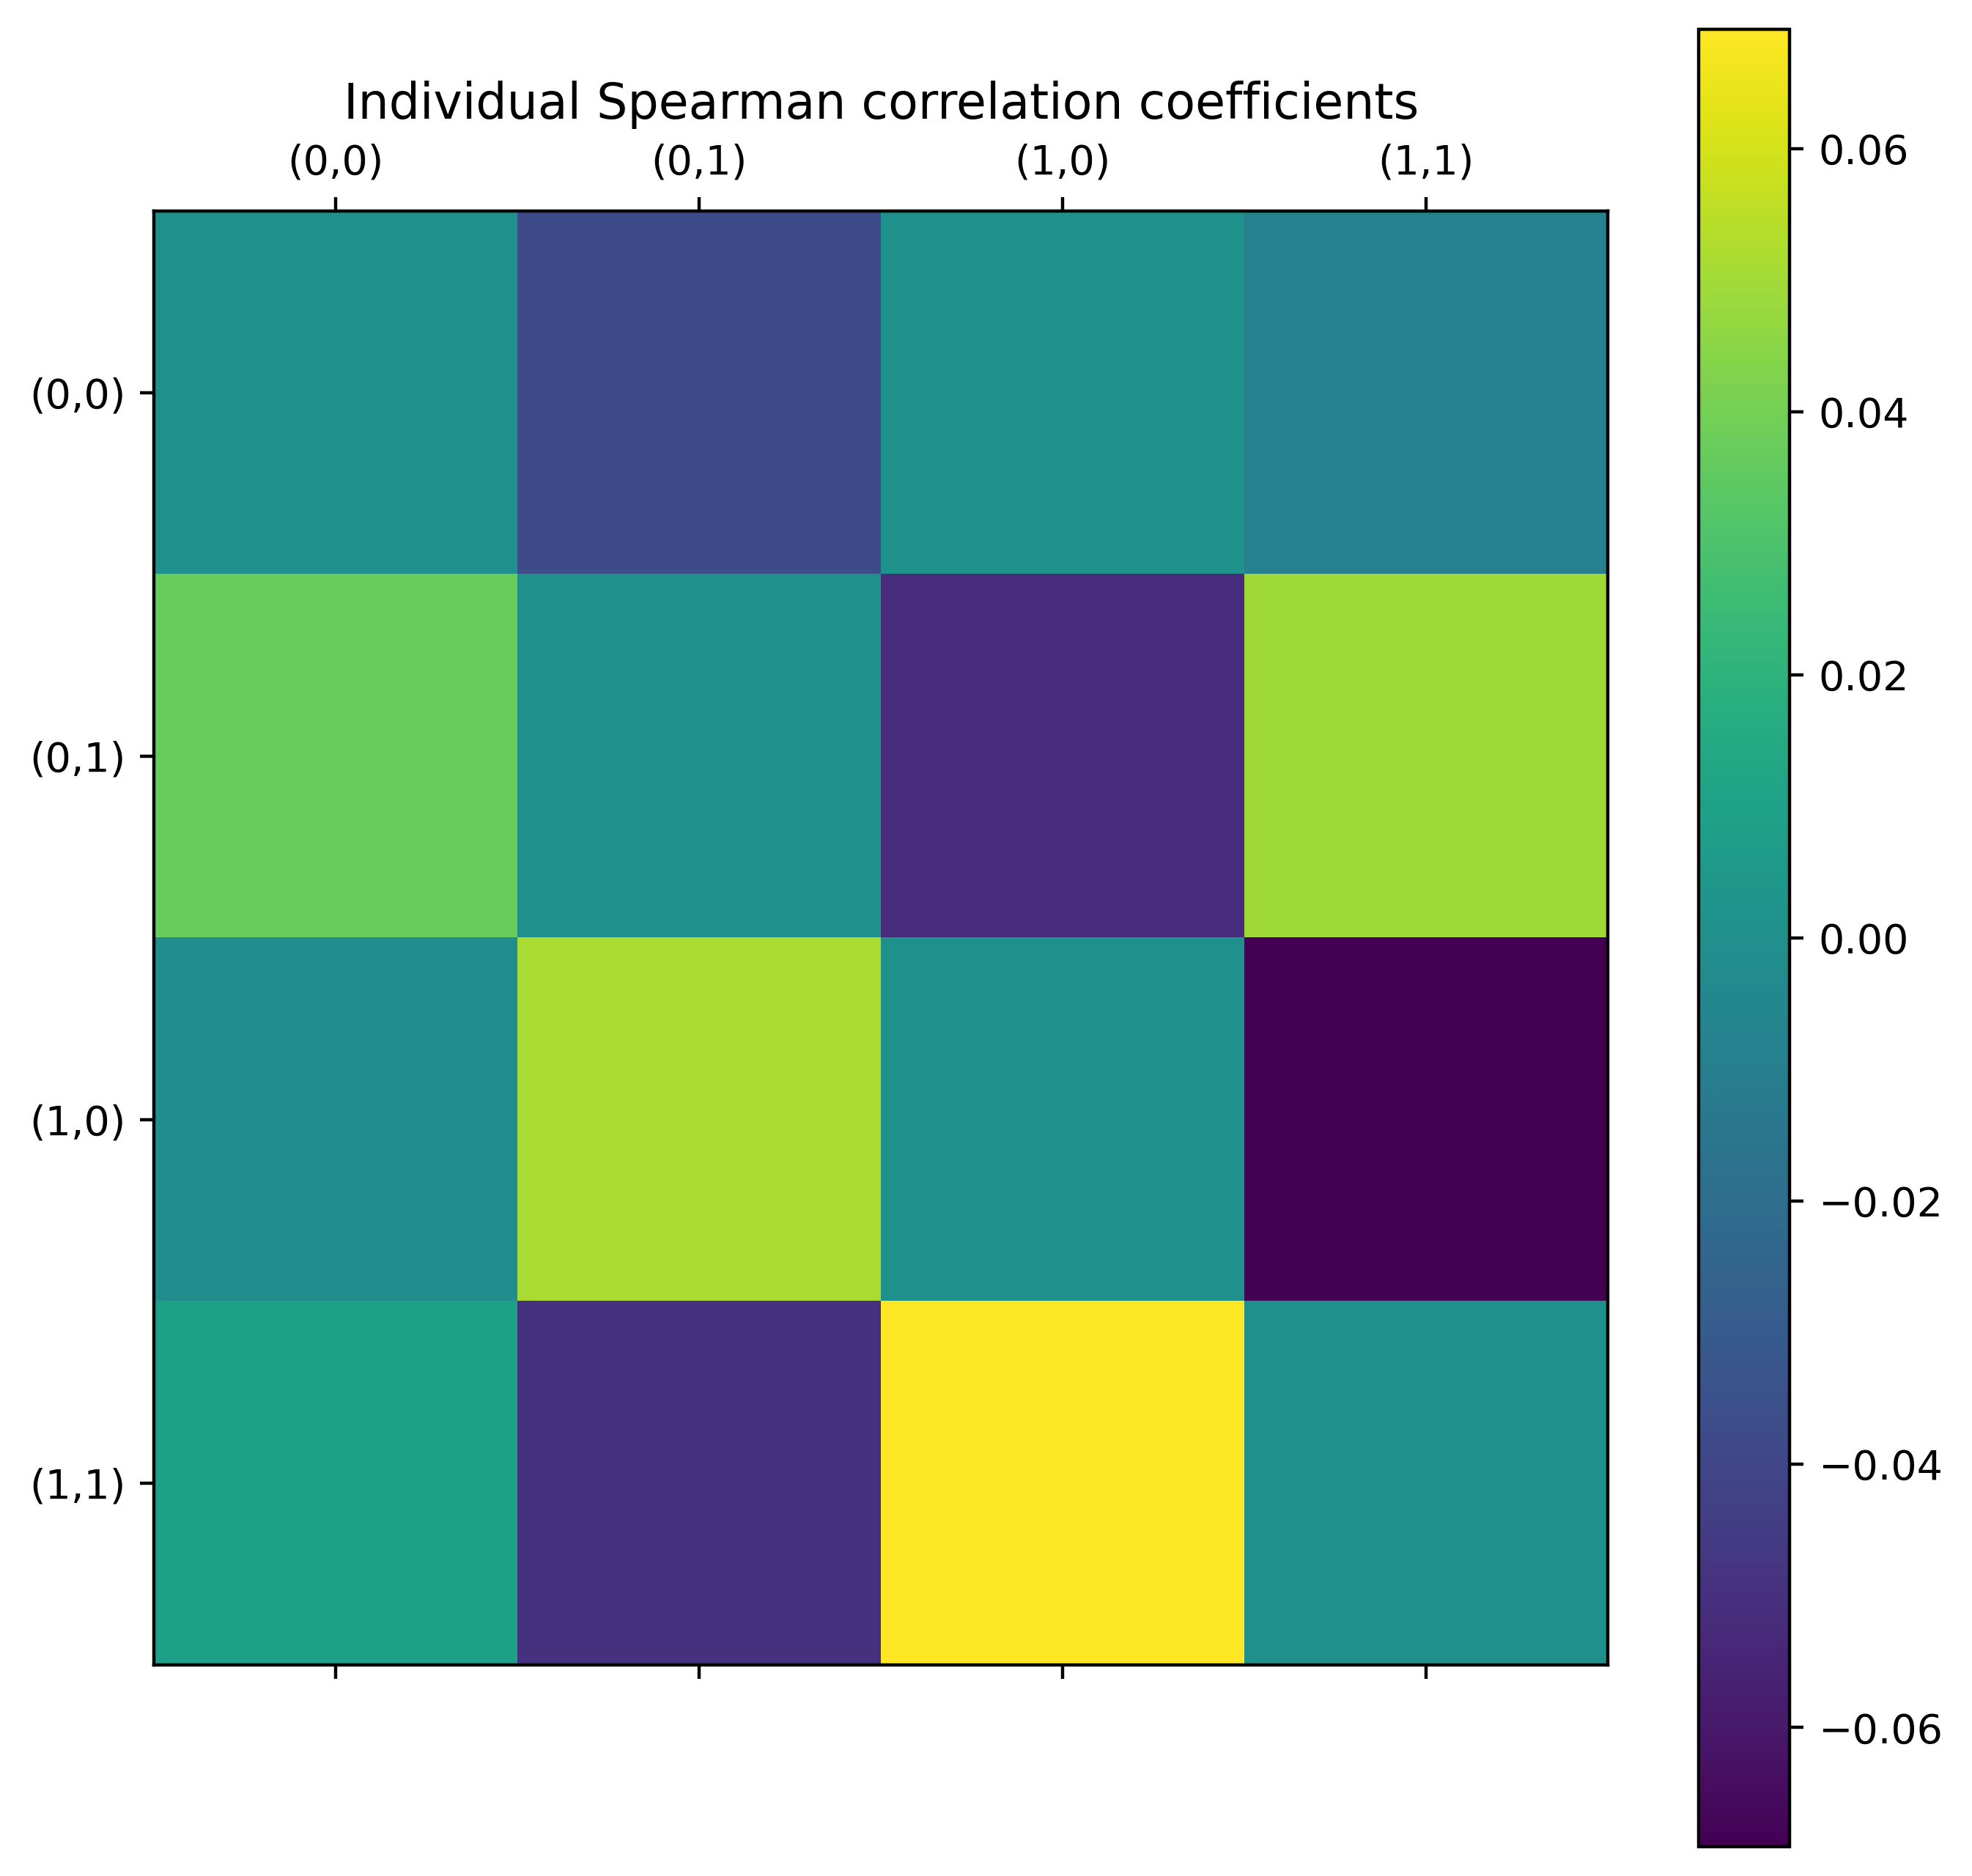

#### Parameters:
* seeds: [10624290880506448623    88367822210422595 12128892237774433960
 11836834552367764202 11142450539845030791 12339828413338438562
  3585998935840772928  6133640949575907010 13863509047048372197
 13360946318707746811 10055462834226158194 10185867923062290616
  6831465312952821929 13831505638381307688 10139575534369627984
 12834323888900436518  2657988187562593271  5871956320167309347
 10679411928377334955 11590234659475996008  1801519633186424959
  4580326008247771858 13555938356313463110 10081095761573340688
  5910541069889222822 13817010170522583558  7831606677765525612
 13288262788215495673 11784890085450422736 18293951435712476313
  9912867052728177636  3875297161267636383 10212069085378575166
 18400214331448307657 17827179798705262651  9406909228908956423
 18304795805382419620  1226381346403692779 18215608311146611098
  2583267847307815027    61787770128478981 17877503732705482109
 12435782633664087504  1016932423190924833 10444227115732940628
  6678339628680747658 17311268730981507872 10497846863183962526
  1857949941666381698  9780964578545206380  8807880909192209082
   647696899356656701 10756408020393986281  4106355183483096461
  4045401529238549349  7611287572140756900 14429584466805822541
  8277875108562324360  1637105843302122730  2768935255490529188
 13637339516681714813 14672153038804092100  2870452023965905564
 11939022502794751204 11734641268378369783   146832838055025666
 17295580247610470678 15960569604917955874 14275342845121110672
  7737603955339923668 10704058572447862049 18161515112655226132
 10652930787933897584 14381551742833238701  9403154801526061183
 16086685275502792712 10593648646392299326  5790855399134045903
 10734602634277039198  3617893336405267352  4932380447721694305
 16943757003200850955 15453638476962259403 17955831243973500828
 10633573758089092025  1447164672353024473 15189110284520764121
  5014150638397619570 10636501978357776329  6541279715236693185
 14903602765936684329  5608185272970557502  4723720896194581399
 17985487677142580137 13232825613799775413   152291519906990701
 18252552985708569914 17264269547854574330 13451112483093303606
  1470729392288013161  1817620447955132912  3755750265290030741
  6757359939681766969  9705491489141041512  1455925248594253857
 15762980492676387910 11460289531422659030 16633711412167900438
 10540844970728921343 17307104084884351099 12715675089511866365
  1336834868236938987  5397918836058397757  9909163853435030146
 12539316142947324080    80485180691116148  1167834534273590706
  7173986213607228279  2710948671100658353  1763262365897851503
 12951776969701951436  2225841578652081348 17619916337556606092
  7623290391259291952  7641097223160421133 16629060511971492243
 16535612096137565112   835602759030829740 17284435526218108184
  9630685648439409435 14572959540313038785  2858852065533503664
 12149948464957550435  9080910219266563148  7929143719170787947
  8484528271281964552  5685238380061469716  2041650227649982273
  2076385631013925916  5596344461545106539 17951071319529410659
 12143397516428016783 18240210352435120902  8988047064781089317
 11058162110329817232  8669306790020016937 12706222475665012729
   467421101715106458  4639935246283652805 12056835062345504123
  9957005103927002732  8837189857775328071 13249109265129879017
 13006123916043264669  2279903627718725833  8325946663724947203
  2117333962449696313 13438108711477030211  2965950441772181356
   449939943880637496  3032294252064593641  4166336406946980484
  1771880259742426996 14946298957084502551 13034155124179669581
 11234902330082831848 12896763672750180200  4424870790305541686
  7409364625921696063  2061518819519746631  4870076345500295997
  9106537010100931632 15838242369028570818 16827619814858441421
  8019948940757551474 16513571305915097497  7567693245736774834
  2481789975614042123  5274443834354539669  5971855985098828568
  1773366824864875170 11885445849836879800  9569105579667640711
  4149583587334871055  8996212012220362831  1354307806567701972
 15485828085919502860  5650672939862837667  2262670173673800640
 17253291041443131390 17642568579261280394  9887891554296745786
  8979314399534994956 17036363897616354174 12546409777998183750
 10560410226446435265  7198693557109305505  5988202804923518254
 13058262429802302794 15337983763832809089 10574101122376957327
  5368651305427444832  7827793256110850676  7616829143043988211
  2790554067218913391  7589475936072310021 12455293924521893590
 15825412761645415409  4048036856693333573  8839360470749572748
   586804386388905097 11148610988921433585  1954901292527793364
 12488549150108400319  8400414418233740322   640225321341627248
  9872492650394831485  6413490641268205402  4046648025035307600
  6396474674023839696  4132195852052215039  7437656970936009925
 17821694765780549321 10892885103847052928  3833893193068583618
  9004640924931727279  8740097165529542440  8014853187760891710
  7405108627798123596 11361344265467571993   602578461601520173
 16766221320204442583  8465161072194783769 16315106569333198502
  7952223031900527622  7238045751784577914 14187571864814808085
 10834595543033932275   598713510925241263  3728900939419962828
  6999842061278618591 10262200012924412857 12279763276914195807
 10567771315165254254  9583657688880932502 12893654889177987085
 15115526673281781321 11551506078465977296  1278277955695163285
  1599155088969052111  4444638030182908915 13819426862385389746
 12936267409409006333 12998425671978203457  8205817873318283853
  1574197700545937479 17852790373549134627 13683756284505871888
 12918403467553092027 10134598366865613548  1988694093769516554
  3886527535778067013  4159876625076139329 11356926820836086966
    39570466366396474  1620072405743937195 12408779602028606258
  4937825834271390773 11740939035019406471  6771503206109937745
 14166266797041787200  8834245999566036590  1135901894518936759
 13956628326310283597  9999335137297254170  1505478266634375875
  8014883652398958209  3042004265022850922 16825590359659071951
  8308831790604072355  6620432567169194740  8771379827138332745
  2222110593724084178  2466555917194467096  8387101800488857350
  2015477410798882287  7946343368405987541  4172597127873850293
 13249185338068468798  1492182221014948766  9904730956507172110
 12689852888993808661 17983521184372092760  2380419774445657891
  7818330111741498604 11202607312961775187 10680374214376807685
  3690927145311417536 13930646930114191145  9837090749399597877
 10668227405441971807  3360348639311564442  6438163843909896992
 17976760121334384154  9641690853268504842  9740938400915866253
 13654536352989045122  6357044992429001592  3281665293731627788
  5255283384729310478  4115575785930731494 10443667361754311441
 15237952768375959215 16347566813453305461 12785450159187974290
  5500690522259277496  9958174329039260238  5101637401979752526
 17748731398618451063  2641467403824643971 16217630048846965555
   756188972330890699  5192417590420344992  2228599762822474377
  5095083660491273768  9821324726187864216  5704519867919185608
  6413578483018663186  4842220036227503652  7237384423128365029
 14670610693821589642  6146229728685869189 14123392102265706184
 13626256582182819378  3885128942195248629  2071664778945759031
  4846822981388228686  6263273648246244226 15070824245837137247
 15418580958510743440 15651297293787201540 16697484503674912147
 11424481790043411250  3723207188833363699 14253051923677843268
  8282622131161194430  6624745626563051923  4572737676626919766
  1358338971697918515  2873247673970705384 13180724107369129828
 17338343472779133746  5723286995249037421  3592333458120466923
 16394526445676175889  5869105866058122833  3002744614185788546
 12190649091605942627  1400488194119479978   966685620131137581
 10146045558302002925  4482718902894013343  5931624493972446075
 10036961966977045954  4268793256568344214  5628578067032140455
 18441773375051297010 14493933416080469494 14499823672388591482
 10205983478242361069 15319763191593905617  6681912106684389669
 11172230879394205586  1291500815277819052 15990429685957964470
  3507116528527477632 10226159922869136390 16549168884501213486
  6777585449852212953 16819852624323058968 15158041773285789514
 15423379656338350329 14878414058317763673  7844784965760585500
 16913637741173753511 18429870306302262177  8326986259021460841
  7121620061221717751  2027930579227501916  7090865833173164789
  6761810862713001785 13238840784437125187 15973959471117717826
 12153499184395660025 11111494514287944180 16234404114808069231
 17313861195225157301   821148299108881814 15853691326396124121
  7464944326321361054  7590949630392726363 16504241095190528917
  9669386123960238598 11089027358953062041  4318372999857259756
  4518291814667377586 10766009096457919537 16497223795723008769
 14085667603081186742 15538865226103382846 18337378508897703681
  6906579827253047470 14142364336775514384  7880503405587090031
  4005749828321142142  8490722810887446529  6270099265841676798
 14472261064991892736  1598338975856845721  4832275794702239175
 17703198386383094309  1538058913343286797  2694068683182702901
  5416097597195494829  2877708978901898608 17721591841227912226
 11240621350781843294 17403806484429676061  2559107151757972826
  1872553139144420265 11706652927707237377  7046753330863664439
  3936948491311334796  9413865571760436867 15521283551207408475
   740295029810269446  2898260597489808777 15275426040540279953
  6474545313978462335 14224902494607465869 13918318542311537430
 15329054931566174814 14473322439465547084  8529461979749311588
 18262934454257126687  2079880035394176151  7045547938250265219
 13510958424969756632 15220842034084180267  9001603055832516465
 16655220297822535753    57535060311353521  7537916186370283094
  7679289045012381920 17697740836832189837  9834946305461088770
 17483866120812257079  1228584677615990844 11812704195076122715
  1150329611405305451 14995559738662293069 17172712138577372014
 15967280227922766739   421628616028733321 13117358015098595622
 18328815133174817946  1088892665065731193  9225953883382910717
 11491648165304362067  8746538164043284105  8662699876843349884
 15206970371222434022  5865174291679049657 14149097486513929556
  8922097113122410080  8501386119174502834  5745699459394327120
  5752165052493088204 13886706339138565280 18133943407242910298
   195632675280018597  4131012797013709637  5174015767063657305
 14239334680130987951  3351624343800469071 11253210570685951674
 16727414153683359671 18071107123361367052  3542988572332036518
   691440169919259859  2301119284163887420  3328558137249264948
  1841903393832791144  5233733850408387617  4872762994407297684
  4684051654010874208 17589116154259010420 18251997283748580305
  3266996048662074323  2215246763195742759  8852500903989757952
 17854290750549017750 11265834787714409174  7774401464436997797
  9384953731678923634 12126247717851971144 12255957030004227338
  3555306906554733029  1899463799653405864  4410985716131740432
  7824242452719569665  7936226496005147327 17719660972152992497
 18413837099162007000 15587098894442652735  8056926153262556873
 16227918862741509189  7679810913652372365  9642776850338537756
 12097504470825462589  1736104656861282573  3646323266653406190
 18129745831501764300  2923624771419715525 12325750767232482507
 11032561153393050278  5160580710844734719 11029921401979661965
  2604188123512436690  5095626111351107296  3914252979430867321
  9527752567676134761  8674618618663226761  1872731723475349254
  7638319445528024858   252944328533983822 10168140873040306162
  9693486787644633707 16951899593285827655 14771876491958647166
  1056970115900166266 13277652141851089597  9185511277208455591
 14740416832478341363  1625337404942683114 16582113807004896338
 11468718824195177580 11023055035819586805  2866950097292216019
  3916939730666127411 10897161600022564553  3392769513783985958
 16415495430448745565  7882208007111480586 17959327793772136098
  2019302044781932244  1877048112119931792  8333209577496314862
 16303190184736792022 10752559065551724590  6646796811222897975
  6618263440437502916 17466035464712606055 13379435315170665207
  4097424935277335371  7076971757108718284 15146984037636346602
   564557706999907597  1045750162740957809  2142708678368771782
  4214576819475012813  2878613822135881410 15480215190145249650
  6357578432780511325   783708185358366094  5506533805436510094
  6432282248404798379   220030030179041881 16744727745336106209
 12357605506668812464   988680131266536541  7176888988785736425
  7680398624068828323  6406570379002267653  1264421669301945165
 12380513467805858995  1986550157488966617  6754817670763084315
  3726824492944606711  9201541139386527965 13027885597395016707
 15127285049618198400 13918334256710756419 16090503089042208083
  1100954380668656444  3898555699054845575 16250256670546042900
  4799489576819569997 10274430464650345109  6218880200700382733
 15931086415727376565  4834696132405390246 15147765975541577026
 14727162557995055413  6545443689439272601  3869929343135527407
  9639048122330355804 15203041280396406601 16189925455458292080
  9821607719121687176 16750527535550542548 11908017636497458690
 11046068087829352273  3358844707042334577  2385875183093824365
 13318698799181057363 13273157645663366115  5381482951193585229
 10857292284764969606 13433299558502319971  9680274628321961518
  7125806422500250181 14655525536481108036  3295963224743269646
 18216651999228739631  6035555044806753996 16386171014444912101
  9250647741564314031 11740992898159158168 11965602860171781209
  8719195226208056952 10988931425475534976 13031770007970393666
 13079671007806332100  1101632647246271696  1375693349499731272
 15355655299117882094  4302016721964036467 14892008218480881007
  4245042087565451856  1815199086500940372  4075232628291615422
 15857207532464264154  2052731754469940030 14275354530859774241
  2903309966740116872  2661536766138572926  5429377996931929101
  7199120513744170711  2901951805979733922 15741946894348068420
  2771737467006944501 18052013744377853510  7234945537995388862
   401503008814578392  6889997357250323056  8493234114059668976
 14303810767617202845  4866165111075241628   886206128350743515
  2096297654817981468 13923803449199720686 13418980716817191813
 15806560013108589952  1632831557054032468  6524619952472642703
 13428885952440534361 12589762842054328616 17186193707843783563
  7602812582001397745 10218011057093172802 13016826065513283059
 10854629231353925336  1474341530409842586  6096036763832520951
  8077807214133261316  7415453693133789297  2047332407351913350
  9001109631491152634  1900189630129118489  8016669204194247039
 15046825386031702420   625165565444622612   795860238351014634
  5172778589703213399  5380933472870955822  3485426430268682165
   110675202743629800  5858175920367222087 10895811029226897217
 14302185531793765053  8153210896735718550  2547966107977583431
  9059554097231147302  7139667187620627568  4376802920244723985
  6748999575421293871  5037120770103442524 13019091001124279428
  2925106968575909767  9265516019495457297 11855841031468673187
 16040417577479532824 11032117737404816113  3699641071427217933
  9402932671537435204  7001450463162406636 10009711818524346933
 11989257506075458676  4802383847811629801  6231867851629508224
  1212416425839091990   724055543894786086  6605397459307973022
 10349317981013415385 13425953789787371956  4055832668029129911
   960229372584251046  9253377278916768825 11621371872906059952
 16447651043487340761  7198900785596801788  3151614189138540812
  5714689772672854663 14627144203226721322 12856981362849373700
  3454646712732579246 14552348725194861257 16448318674640653288
  3033497928572731514 15830568273979809261    41604530197903318
 13789601350098545270  8955778037508698088  3664085559383868190
  8032037647676157421 12791241082743659625 12931674786492350670
  3572914819534060027 12437427212513855040  9221452406488558866
  7472603066611513969 18041845738179924763 16985205735613682991
 14479540243526588259 14240632469579208652 18014804227074915174
 12388877002969878030  6188541915946134537  5040551817198047368
  9095483945001646935  5386054410289354983  5009550706001912785
  8791644720920795030  7021158024827369418 18384343321960057033
   908369735013000902 16485556943149565634  5181761448284821650
 12603074415007601217 15724100734711800094  3500468697782590090
  8548574354789800952  3029891931247957776 18108812196505000160
 13205440356033367796  5394311221515621030  2717094114801716517
 14778987812232749125 12888939787912735852 18390459161600356979
  8660949742587366728  4992448820141047289 15719212607953015672
 12288090840962304870  5033249352469173348   701820088672075074
 15221699286629806713 18411374850059038255  2076788119304422168
  9774349251721837128 16717435350513864272 16944236773507885429
  4018680522925598773  5033671170079465736  2418373378551333039
  4487518463351170943  4073819194877344853  2934593129238182746
 15935820307807675082  6437598847222697454  1904100252805811415
 15138046046883145669  2644847917773430401 17736295607486506019
  9592036094475906433 17006549226141398337  5790728163936680090
 16604065609413725327 17422570138599260332 13538668505956507989
  2762879781131189157 18198132922596648246 14981425100556072593
 12706958002331876833   901494043413784994  8328613719582484387
  9669487057669548260 12778202260968829622 13580141808993765943
 15100789760740993644 11837964954858210323  1296504941777324093
 12984413322138860201 14170703813977207460  3196465070097523379
 17244071946056214044  6971175842344712255 13302832182726996390
  2234593629054244209  3171341326918859376 14866390657005454485
  4262362607826162470  9460789824112784124  1490822934001484085
  9579966054395934628  8963567628257067946  1875088126115471023
 15142480147337508198 14652502782490149286  8384238665884923960
 16535836943564745984  7296933267176757964  7413719414290428862
  5586250446174246854  8101569274795744894  9888567846446692205
  3173838075360163990  9844859991128193662 13259516468616858729
  6799764109948047986 16722945560316501616 15771233180307223795
 10178362819530276231 15769948358900371681  3045961876150725783
  3617736530029801813  1022527092071084437 14810915437938133691
 14106037240311977622  4201037055254179601  5627713833638925018
  2667522138258044157 11380805506785495512 14583367699678162908
 10015560412669718810  4443296481340436511 17845541095300478266
 12775211585513199069  9372117044649185052 16859874206739721894
 15203635843793765114  3621626352959573521  7119277972561363574
 12671376720236037425  4847399107620634936  8651265016762302130
  7016853102048310545 17073666520925604231 11185565264512468240
 18106850562779307212  6882415433189612391   258999576856104497
  5485387202617279363 13568137971339808739  1249006185368455428
  9683109446917052779  1323063659230893461  2472568890157063850
  3712709589534874969 11598626118204416056 10051068146499086437
  1934692981197616407  4316429182603843816 12885418355084960542
 10858332786159435702 14846577088576066224 12471174207197944090
  9929634214512790580 14326074745234029134  9630763453796450098
  8390528576856814344 14321084142615245071 10085631284827053743
 18158926218985765342  3593782073267503125  4605820997630599078
 12706364535195829786  4742160147048939357 18009217503140922854
 17893864364819386516 11407939442958831752  9057448007913589514
 12659938134522370746 11119583864660433435 15094112786132485265
 16889627529776571603 10540588893388903489  9137649588608196801
  3650201623364944374  5473759200718655358 16210045906159630024
 12797715898517983043 17462988569923743627  6339290940283244847
 15445728981094420584 14187278789840107055 16258650347932900857
 18183951927742476281 16754121688463227619 11376547530965680583
  6148564387156239963 12492618227874202819  1665940472445528627
  8644783713096332753 16047297643500660778 13550742893154106480
 11394936405939568044 10006590193584654901   312889233162758807
 12582524119921578066  9369832059475118965  6350189372119997872
 12190914313280786291  3288052414625801993 16458939255401611108
  4135679047330002736  2793577419913791731   828673275627490059
 11200038870278810882  9082470813881078402  3458864422095562038
 13520389932385286267  6500206221161540165  6546210866800945298
 12535580188088977231  5364753669473696672  4793293896595045531
  1968124339714010513  7173575021203781782  8055486196066071294
  2441499306064797294 15991226466916219979  5456969679535619999
  7055894117060039858  4573286433332302959  3608716421280560433
 13021038070495648573  8027402333035290149 17856491849973128549
 11986201096895449511 10805276390193417806 11029491279682182782
 15485762712037634089  4079035017322563592 16836496351707351612
  9802667951748549959 10881614037754553709  6190123207640959519
  4826400631575174728 13104384664426968085 10676515012560852675
 16714440196938241299  2361107771792107672 18284035740869987047
   247091358789155017 11087828591583005239  7821876042399248464
 13283986611579526083  6096772675392817064 15532111952215131433
 11026841621526649569  3156077090468851680  9585055131267815986
 10734714646090506053  7277979369989455023   739562798519100360
  4395834636061641479  5406159775898648059 14068851516546387118
  3444663477857746331  3979067718974591754 17921872231835958866
  2579934784727603220   439008826485558304 15771249154647550050
  7339602462950516934  1198701692790333170  5515679441253810688
   362281203788468484]

In [5]:
for mode in ["NoDispersal", "HighDispersal"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000)

    test_rng_correlation(mode, seeds=seeds, limit=100)